## Load Dependencies

In [36]:
import tensorflow as tf
import numpy as np
import math 
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
%matplotlib inline
np.random.seed(1)

## Load Dataset

In [23]:
def load_dataset():
    train = h5py.File('datasets/train_signs.h5','r')
    train_x = np.array(train["train_set_x"][:])
    train_y = np.array(train["train_set_y"][:])
    
    test = h5py.File('datasets/test_signs.h5','r')
    test_x = np.array(test["test_set_x"][:])
    test_y = np.array(test["test_set_y"][:])
    
    classes = np.array(test["list_classes"][:])
    
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes


def to_one_hot(arr, C):
    return np.eye(C)[arr.reshape(-1)].T
    

In [3]:
train_x, train_y, test_x, test_y, classes = load_dataset() 

y = 5


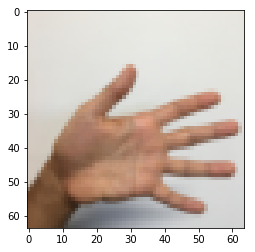

In [4]:
# Example of a picture
index = 12
plt.imshow(train_x[index])
print ("y = " + str(np.squeeze(train_y[:, index])))

## Preprocessing

In [24]:
#flatten
train_x_flat = train_x.reshape(train_x.shape[0],-1).T
test_x_flat = test_x.reshape(test_x.shape[0],-1).T

#normalize
train_x_final = train_x_flat / 255
test_x_final  = test_x_flat /255

#one-hot encoding of output labels
train_y_one_hot = to_one_hot(train_y, len(classes))
test_y_one_hot = to_one_hot(test_y, len(classes))

print ("number of training examples = " + str(train_x_final.shape[1]))
print ("number of test examples = " + str(test_x_final.shape[1]))
print ("X_train shape: " + str(train_x_final.shape))
print ("Y_train shape: " + str(train_y_one_hot.shape))
print ("X_test shape: " + str(test_x_final.shape))
print ("Y_test shape: " + str(test_y_one_hot.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


### Placeholders

In [26]:
def make_placeholders(dim_x, dim_y):
    X = tf.placeholder(tf.float32, [dim_x,None])
    Y = tf.placeholder(tf.float32, [dim_y,None])
    return X,Y

### Parameter Initialization

In [55]:
def parameter_initialization():
    
    W1 = tf.get_variable(name = "W1", shape = [25, 12288], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable(name = "b1", shape = [25,1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable(name = "W2", shape = [12, 25], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable(name = "b2", shape = [12,1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable(name = "W3", shape = [6, 12], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable(name = "b3", shape = [6,1], initializer=tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                 }
    
    return parameters

### Forward Propagation

In [56]:
def forwardProp(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3

### Compute Cost

In [32]:
def compute_cost(ZL, Y):
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)) #for loss formula
    
    return cost

In [47]:
def make_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    
    m = X.shape[1]                 
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))


    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Model

In [64]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 1e-4, epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []                                        
    

    X, Y = make_placeholders(n_x, n_y)


    parameters = parameter_initialization()

    

    ZL = forwardProp(X, parameters)


    cost = compute_cost(ZL, Y)

    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        sess.run(init)

        for epoch in range(epochs):

            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = make_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch

                optimization , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})

                
                epoch_cost += minibatch_cost / num_minibatches


            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print ("Parameters have been trained!")


        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters


Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572940
Cost after epoch 400: 0.468774
Cost after epoch 500: 0.381021
Cost after epoch 600: 0.313822
Cost after epoch 700: 0.254158
Cost after epoch 800: 0.203829
Cost after epoch 900: 0.166421
Cost after epoch 1000: 0.141486
Cost after epoch 1100: 0.107580
Cost after epoch 1200: 0.086270
Cost after epoch 1300: 0.059371
Cost after epoch 1400: 0.052228


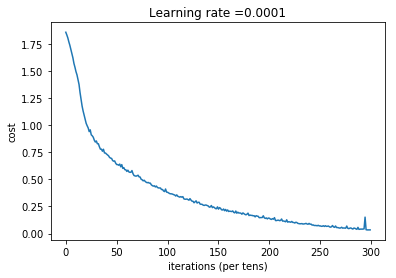

Parameters have been trained!
Train Accuracy: 0.999074
Test Accuracy: 0.716667


In [65]:
parameters = model(train_x_final, train_y_one_hot, test_x_final, test_y_one_hot)

## prediction 

In [109]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3
    }
    
    x = tf.placeholder(tf.float32, [X.shape[0], X.shape[1]])
    
    ZL = forwardProp(x, params)
    
    idx = tf.argmax(ZL)
    
    with tf.Session() as sess:
        pred = sess.run(idx, feed_dict={x: X})
        
    return pred

## Testing our model

Your algorithm predicts: y = 4


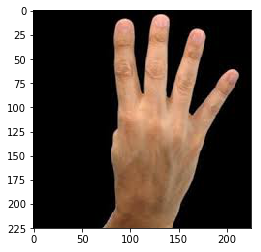

In [119]:
import scipy
from PIL import Image
from skimage.transform import resize
from scipy import ndimage

my_image = "4.jpg"

image = np.array(Image.open(my_image))
image_ = resize(image, (64, 64), mode='reflect').reshape((1,64*64*3)).T

pred = predict(image_, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))




Your algorithm predicts: y = 4


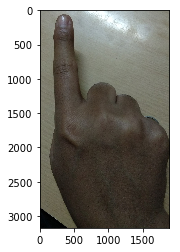

In [120]:
my_image = "1.jpg"

image = np.array(Image.open(my_image))
image_ = resize(image, (64, 64), mode='reflect').reshape((1,64*64*3)).T

pred = predict(image_, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

Your algorithm predicts: y = 4


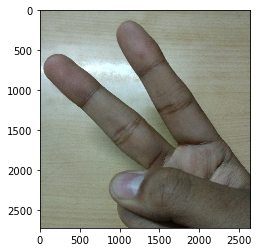

In [121]:
my_image = "2.jpg"

image = np.array(Image.open(my_image))
image_ = resize(image, (64, 64), mode='reflect').reshape((1,64*64*3)).T

pred = predict(image_, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))
